In [2]:
import requests
import folium
import json
import pystac
import rioxarray
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
sas_token = "se=2023-02-13T19%3A15Z&sp=racwdl&sv=2018-11-09&sr=c&skoid=b4d39ccb-ca9c-4e9d-a183-5e0f3ba3e609&sktid=f6b6dd5b-f02f-441a-99a0-162ac5060bd2&skt=2023-02-06T19%3A16%3A18Z&ske=2023-02-13T19%3A15%3A00Z&sks=b&skv=2018-11-09&sig=z/AIiFdLunJ/tg9i/gJUqvLRgRxghWgXiIyAm1sV2Zo%3D"

In [4]:
#URL = f'https://snowmelt.blob.core.windows.net/snowmelt/eric/MGRS/10TES/runoff_onset_10TES_allyears_median_40m.tif?{sas_token}'
URL = f'https://github.com/egagli/sar_snowmelt_timing_map/raw/main/MGRS/10TES/runoff_onset_10TES_allyears_median_40m.tif'
da = rioxarray.open_rasterio(URL)
da

<xarray.DataArray (band: 1, y: 2745, x: 2746)>
[7537770 values with dtype=float64]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 5e+05 5e+05 5.001e+05 ... 6.097e+05 6.098e+05
  * y            (y) float64 5.2e+06 5.2e+06 5.2e+06 ... 5.09e+06 5.09e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

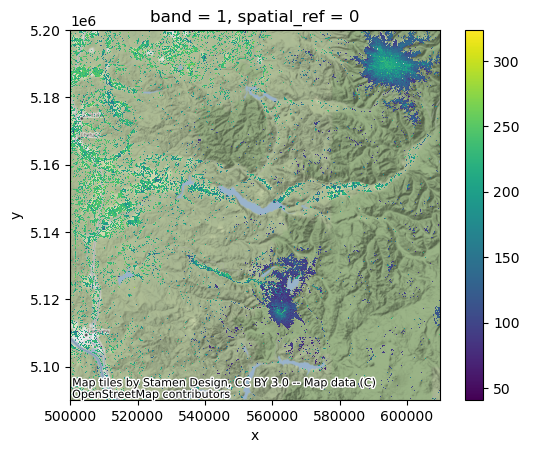

In [6]:
f,ax=plt.subplots()
da.plot(ax=ax)
ctx.add_basemap(ax=ax, crs=da.rio.crs, source=ctx.providers.Stamen.Terrain)

In [7]:
#!pip install azure-functions
#!pip install uvicorn titiler.application
#!pip install uvicorn titiler.application.routers
#!pip install uvicorn
#!pip install titiler.{package}

#import azure.functions as func
#from titiler.application.routers import cog, mosaic, stac, tms
#from fastapi import FastAPI


#app = FastAPI()
#app.include_router(cog.router, prefix="/cog", tags=["Cloud Optimized GeoTIFF"])

In [8]:
import branca
from branca.colormap import LinearColormap

cm = branca.colormap.linear.viridis.scale(0,365)
#cm.colors.reverse()
#cm = branca.colormap.LinearColormap(colors=cm.colors, caption='sqrt(gamma0)')
cm

In [10]:
m = folium.Map(
    location=(40.76, -111.89),
    tiles="Stamen Terrain", #"cartodbpositron"
    zoom_start=5,
    #control_scale=True,
)


#tif = f'https://snowmelt.blob.core.windows.net/snowmelt/eric/MGRS/10TES/runoff_onset_10TES_allyears_median_40m.tif?{sas_token}'
tif = "https://github.com/egagli/sar_snowmelt_timing_map/raw/main/MGRS/10TES/runoff_onset_10TES_allyears_median_40m.tif"
tiler = "https://api.cogeo.xyz/cog/tiles/{z}/{x}/{y}"
expression = "rescale=0,365&colormap_name=viridis&nodata=nan"

virtual_tiles = f"{tiler}?url={tif}&{expression}"
folium.TileLayer(tiles=virtual_tiles,overlay=True, colormap=mpl.cm.viridis.colors,opacity=0.9,name='2015-2022 Median Snowmelt Runoff Onset', attr="Microsoft PC hosted Sentinel-1 RTC via Catalyst").add_to(m)
# look into FeatureGroup(name=None, overlay=True, control=True, show=True, **kwargs). with this, maybe have toggle for 2015,2016,median,etc

folium.LayerControl().add_to(m)
cm.add_to(m)

m

In [5]:
m.save("index.html")